# Data Preprocesing

In [46]:
# import libraries
import numpy as np
import pandas as pd

from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_qqplot import pplot
from statsmodels.graphics.gofplots import qqplot

## Read Preprocessed Data

In [47]:
# read csv files
# extract feature names available in test file when predicting
test_features = pd.read_csv('data/flights_test_raw.csv', nrows=0, index_col=0).columns.to_list()
# test_features.append('arr_delay')
# read raw data
df = pd.read_csv('data/flights_preprocessed.csv', index_col=0)
# df = df[test_features]
df.head()

,fl_date,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,...,fl_weekday,season,day_num_of_flights,num_flights_6hr,inbound_fl_num,inbound_fl,dep_min_of_day,arr_min_of_day,dep_hr,arr_hr
0,2018-01-01,YV,N89308,6246,12992,12266,18:55:00,1849.0,-6.0,12.0,...,0,1,1,1,0,0,1135,1230,18,20
1,2018-01-01,YV,N88331,6183,13158,12266,09:45:00,1013.0,28.0,9.0,...,0,1,1,1,0,0,585,675,9,11
2,2018-01-01,YV,N519LR,6034,13198,12264,12:20:00,1217.0,-3.0,11.0,...,0,1,6,3,0,0,740,936,12,15
3,2018-01-01,YV,N511MJ,6153,13198,12264,08:20:00,813.0,-7.0,21.0,...,0,1,6,4,0,0,500,695,8,11
4,2018-01-01,YV,N86336,6016,13198,12266,11:05:00,1056.0,-9.0,12.0,...,0,1,6,4,0,0,665,801,11,13


In [48]:
df.shape

(15156, 50)

## Exploratory Data Analysis and More Feature Engineering

### Exploratory Data Analysis
#### **Task 1**
Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

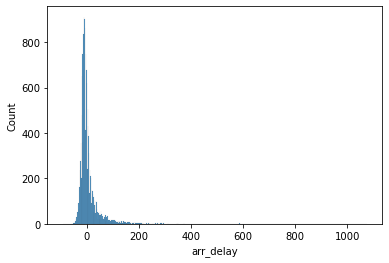

In [49]:
sns.histplot(df['arr_delay'])
plt.show()

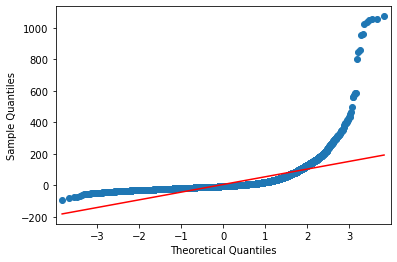

In [50]:
# q-q plot
qqplot(df['arr_delay'], line='s')
plt.show()

In [51]:
# normality test
stat, p = stats.shapiro(df['arr_delay'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.482, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\cfsui\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [52]:
# normality test
stat, p = stats.normaltest(df['arr_delay'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=21945.748, p=0.000
Sample does not look Gaussian (reject H0)


#### **Task 2**
Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

##### Monthly

In [53]:
# The Federal Aviation Administration (FAA) considers flight delay to be 15 minutes later than cheduled time
# check
delay_types = ['carrier_delay',
               'weather_delay',
               'nas_delay',
               'security_delay',
               'late_aircraft_delay']
df[df['arr_delay'] < 15][delay_types].sum()

carrier_delay          0.0
weather_delay          0.0
nas_delay              0.0
security_delay         0.0
late_aircraft_delay    0.0
dtype: float64

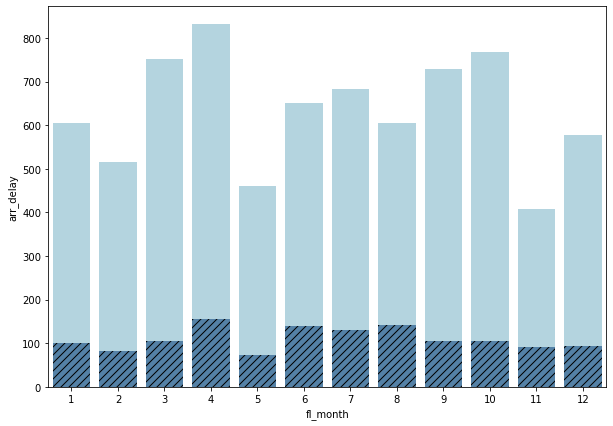

In [54]:
# monthly flights counts, only use year 2018 since the data in 2019 is not whole year
df_2018 = df[df.fl_date.str.startswith('2018')]
month_ct = df_2018[['fl_month', 'arr_delay']].groupby('fl_month').count()

# monthly delay count percentage
month_delay_pct = df_2018[df_2018['arr_delay']> 15][['fl_month', 'arr_delay']].groupby('fl_month', as_index=False).count()
month_delay_pct['total_count'] = month_ct.values
month_delay_pct['delay_pct'] = month_delay_pct['arr_delay'] / month_delay_pct['total_count'] 

fig = plt.figure(1, figsize=(10,7))
ax = sns.barplot(x='fl_month', y='total_count', data=month_delay_pct, color="lightblue")
ax = sns.barplot(x='fl_month', y='arr_delay', data=month_delay_pct,  color="steelblue", hatch='///', ci=None)
plt.show()

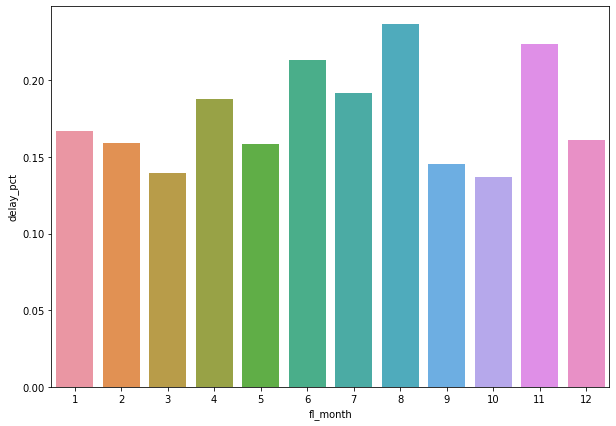

In [55]:
# pct plots
fig = plt.figure(1, figsize=(10,7))
sns.barplot(x='fl_month', y='delay_pct', data=month_delay_pct)
plt.show()

##### Season

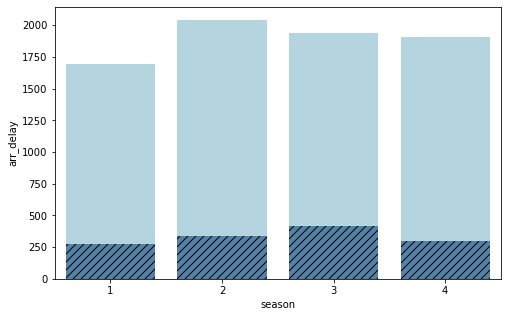

In [56]:
season_ct = df_2018[['season', 'arr_delay']].groupby('season').count()

# monthly delay count percentage
season_delay_pct = df_2018[df_2018['arr_delay']> 15][['season', 'arr_delay']].groupby('season', as_index=False).count()
season_delay_pct['total_count'] =season_ct.values
season_delay_pct['delay_pct'] = season_delay_pct['arr_delay'] / season_delay_pct['total_count'] 

fig = plt.figure(1, figsize=(8,5))
ax = sns.barplot(x='season', y='total_count', data=season_delay_pct, color="lightblue")
ax = sns.barplot(x='season', y='arr_delay', data=season_delay_pct,  color="steelblue", hatch='///', ci=None)
plt.show()

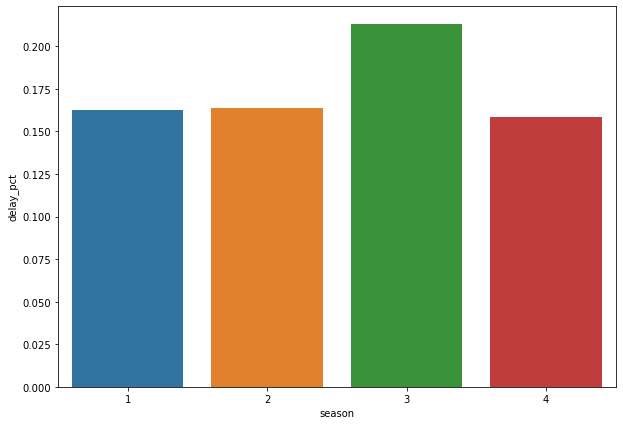

In [57]:
# pct plots
fig = plt.figure(1, figsize=(10,7))
sns.barplot(x='season', y='delay_pct', data=season_delay_pct)
plt.show()

##### Weekday

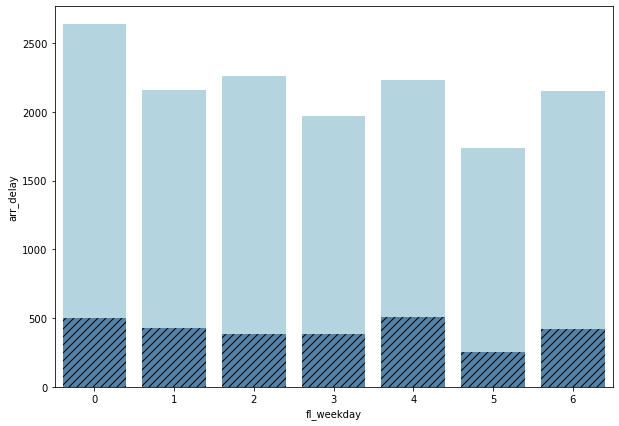

In [58]:
# weekday flights counts
weekday_ct = df[['fl_weekday', 'arr_delay']].groupby('fl_weekday').count()

# weekday delay count percentage
# The Federal Aviation Administration (FAA) considers flight delay to be 15 minutes later than cheduled time
weekday_delay_pct = df[df['arr_delay'] >= 15][['fl_weekday', 'arr_delay']].groupby('fl_weekday', as_index=False).count()
weekday_delay_pct['total_count'] = weekday_ct.values
weekday_delay_pct['delay_pct'] = weekday_delay_pct['arr_delay'] / weekday_delay_pct['total_count'] 

fig = plt.figure(1, figsize=(10,7))
ax = sns.barplot(x='fl_weekday', y='total_count', data=weekday_delay_pct, color="lightblue")
ax = sns.barplot(x='fl_weekday', y='arr_delay', data=weekday_delay_pct,  color="steelblue", hatch='///', ci=None)
plt.show()

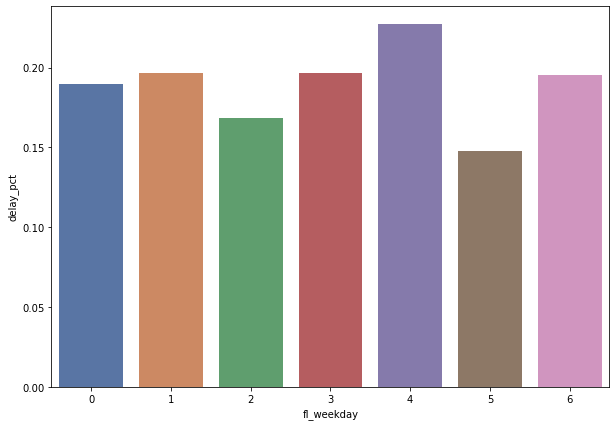

In [59]:
# pct plots
fig = plt.figure(1, figsize=(10,7))
sns.barplot(x='fl_weekday', y='delay_pct', data=weekday_delay_pct, palette='deep')
plt.show()

##### Hourly

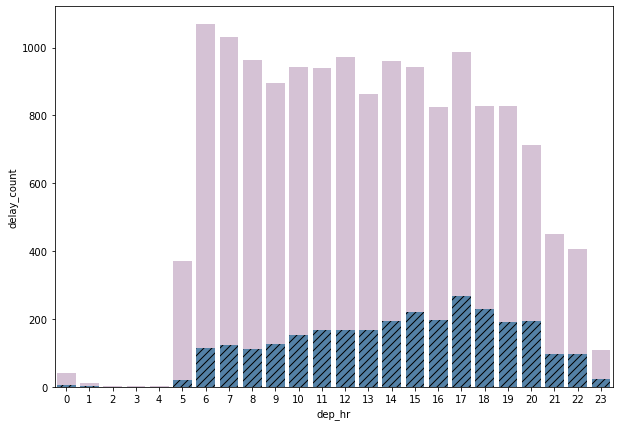

In [60]:
# hourly flight counts
hr_ct = df[['dep_hr', 'arr_delay']].groupby('dep_hr', as_index=False).count().rename(columns={'arr_delay': 'total_count'})

# monthly delay count percentage
# The Federal Aviation Administration (FAA) considers flight delay to be 15 minutes later than cheduled time
hr_delay_ct = df[df['arr_delay'] >= 15][['dep_hr', 'arr_delay']].groupby('dep_hr', as_index=False).count().rename(columns={'arr_delay': 'delay_count'})

hr_delay = pd.merge(hr_ct, hr_delay_ct, on='dep_hr', how='outer').fillna(0)
hr_delay['delay_pct'] = hr_delay['delay_count'] / hr_delay['total_count'] 

fig = plt.figure(1, figsize=(10,7))
ax = sns.barplot(x='dep_hr', y='total_count', data=hr_delay, color="thistle")
ax = sns.barplot(x='dep_hr', y='delay_count', data=hr_delay,  color="steelblue", hatch='///', ci=None)
plt.show()

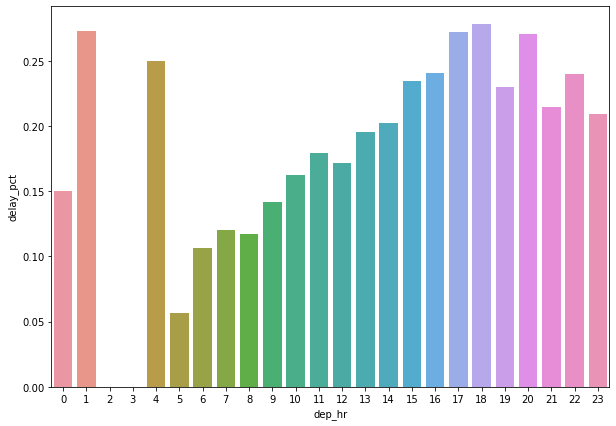

In [61]:
# pct plots
fig = plt.figure(1, figsize=(10,7))
sns.barplot(x='dep_hr', y='delay_pct', data=hr_delay)
plt.show()

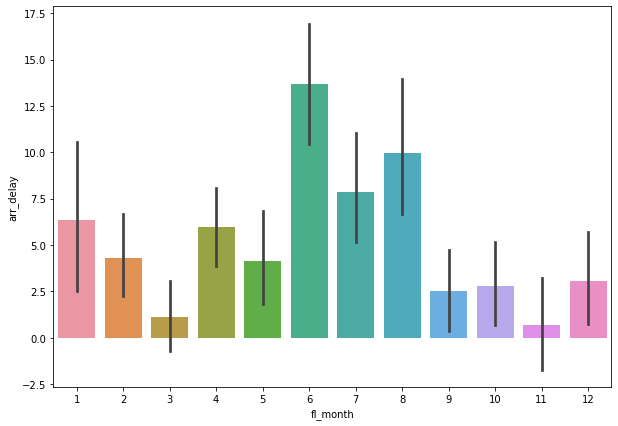

In [62]:
# monthly average delay time
fig = plt.figure(1, figsize=(10, 7))
sns.barplot(x='fl_month', y='arr_delay', data=df, estimator=np.mean)
plt.show()

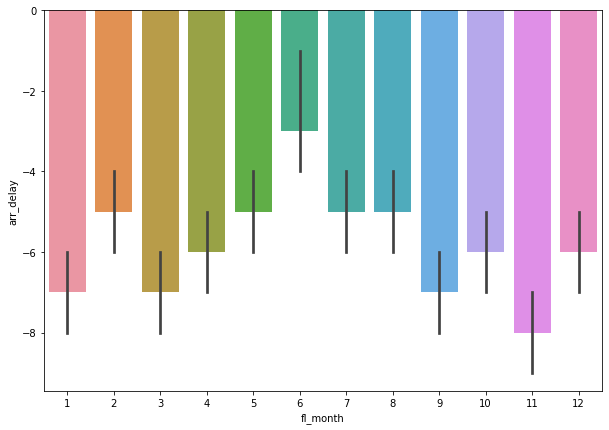

In [63]:
# monthly median delay time
fig = plt.figure(1, figsize=(10, 7))
sns.barplot(x='fl_month', y='arr_delay', data=df, estimator=np.median)
plt.show()

#### **Task 3**
Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

##### Weather Impact

In [64]:
df_weather = pd.read_csv('data/flights_delay_weather_sample.csv', index_col=0)
df_weather.head()

,fl_date,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,...,day_num_of_flights,num_flights_6hr,inbound_fl_num,inbound_fl,dep_min_of_day,arr_min_of_day,dep_hr,arr_hr,hr,weather
13938,2019-03-07,AS,N307AS,684,14747,14107,07:40:00,924.0,104.0,45.0,...,13,8,1,1,460,690,7,11,2,Moderate or heavy snow with thunder
13097,2019-05-30,WN,N8566Z,1059,11259,10140,19:20:00,1949.0,29.0,9.0,...,15,9,0,0,1160,1215,19,20,6,Clear
3915,2019-08-19,AA,N804NN,210,13303,14107,14:15:00,1447.0,32.0,12.0,...,2,2,0,0,855,960,14,16,4,Patchy rain possible
9302,2018-05-06,DL,N912DL,2394,10397,14100,18:30:00,1921.0,51.0,10.0,...,12,8,0,0,1110,1235,18,20,6,Partly cloudy
3263,2018-03-20,9E,N232PQ,3970,15016,12953,16:01:00,1633.0,32.0,17.0,...,1,2,0,0,961,1171,16,19,5,Sunny


In [65]:
df_weather['weather'].value_counts()

Sunny                                  156
Clear                                   71
Partly cloudy                           66
Patchy rain possible                    34
Moderate or heavy rain shower           28
Light rain shower                       27
Overcast                                23
Cloudy                                  20
Heavy snow                              10
Light drizzle                            7
Moderate rain                            7
Patchy light rain with thunder           6
Torrential rain shower                   6
Mist                                     4
Light snow                               4
Light rain                               4
Patchy light drizzle                     3
Patchy light snow                        3
Moderate snow                            3
Heavy rain                               3
Blizzard                                 2
Moderate or heavy snow with thunder      2
Moderate rain at times                   2
Light sleet

In [66]:
sunny = ['Sunny', 'Clear']
snow = ['Heavy snow', 'Light snow', 'Patchy light snow', 'Moderate snow', 'Blizzard', 'Moderate or heavy snow with thunder', 'Patchy moderate snow', 'Moderate or heavy snow showers', 'Patchy heavy snow', 'Blowing snow', 'Light sleet showers', 'Light sleet', 'Moderate or heavy snow showers', 'Ice pellets']
rainy = ['Patchy rain possible', 'Moderate or heavy rain shower', 'Light rain shower', 'Moderate rain', 'Patchy light rain with thunder', 'Torrential rain shower', 'Light rain', 'Patchy light drizzle', 'Heavy rain', 'Moderate rain at times', 'Patchy light rain']
cloudy = ['Cloudy', 'Partly cloudy', 'Overcast', 'Light drizzle', 'Mist', 'Fog']

df_weather['weather'] = df_weather['weather'].replace(sunny, 'sunny').replace(snow, 'snow').replace(rainy, 'rainy').replace(cloudy, 'cloudy')
df_weather['weather'].value_counts()

sunny     227
rainy     121
cloudy    121
snow       31
Name: weather, dtype: int64

In [67]:
df_sunny = df_weather[df_weather['weather'] == 'sunny']['arr_delay']
df_rainy = df_weather[df_weather['weather'] == 'rainy']['arr_delay']
df_cloudy = df_weather[df_weather['weather'] == 'cloudy']['arr_delay']
df_snow = df_weather[df_weather['weather'] == 'snow']['arr_delay']

F, p = stats.f_oneway(df_sunny, df_rainy, df_cloudy, df_snow)
print('H0: There\'s no diference.')
print('Reject H0' if p < 0.05 else 'Accept H0')

H0: There's no diference.
Reject H0


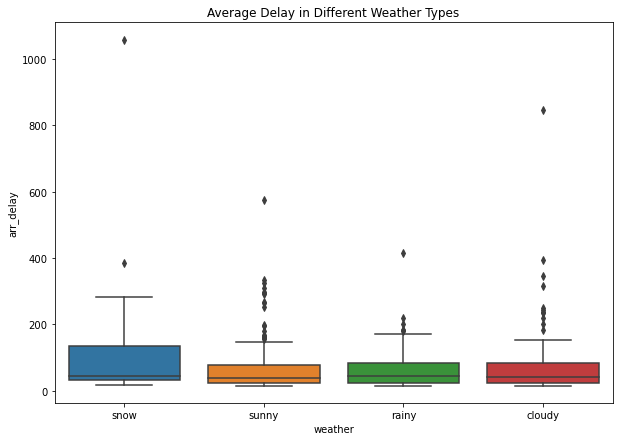

In [68]:
fig = plt.figure(1, figsize=(10, 7))
sns.boxplot(x='weather', y='arr_delay', data=df_weather)
plt.title('Average Delay in Different Weather Types')
plt.show()

#### **Task 4**
How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

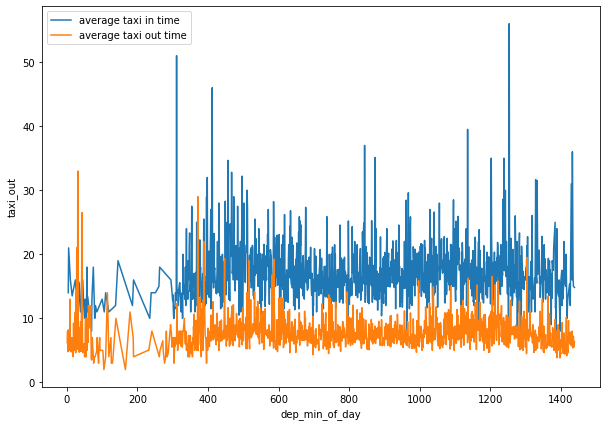

In [69]:
# mean by minute
taxi_out_mean_m = df[['dep_min_of_day', 'taxi_out']].groupby('dep_min_of_day', as_index=False).mean()
taxi_in_mean_m = df[['arr_min_of_day', 'taxi_in']].groupby('arr_min_of_day', as_index=False).mean()
fig = plt.figure(1, figsize=(10, 7))
sns.lineplot(x='dep_min_of_day', y='taxi_out', data=taxi_out_mean_m)
sns.lineplot(x='arr_min_of_day', y='taxi_in', data=taxi_in_mean_m)
plt.legend(labels=['average taxi in time', 'average taxi out time'])
plt.show()

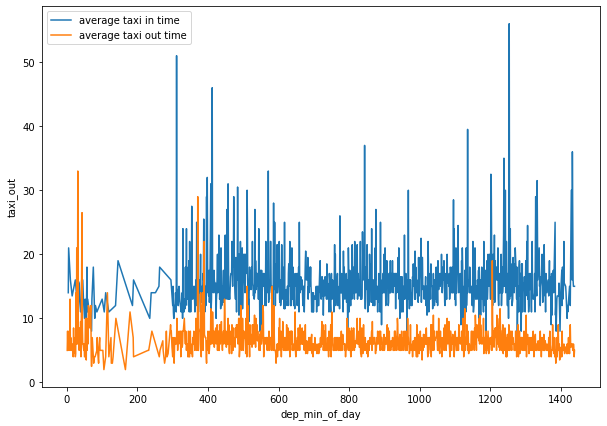

In [70]:
# median by minute
taxi_out_median_m = df[['dep_min_of_day', 'taxi_out']].groupby('dep_min_of_day', as_index=False).median()
taxi_in_median_m = df[['arr_min_of_day', 'taxi_in']].groupby('arr_min_of_day', as_index=False).median()
fig = plt.figure(1, figsize=(10, 7))
sns.lineplot(x='dep_min_of_day', y='taxi_out', data=taxi_out_median_m)
sns.lineplot(x='arr_min_of_day', y='taxi_in', data=taxi_in_median_m)
plt.legend(labels=['average taxi in time', 'average taxi out time'])
plt.show()

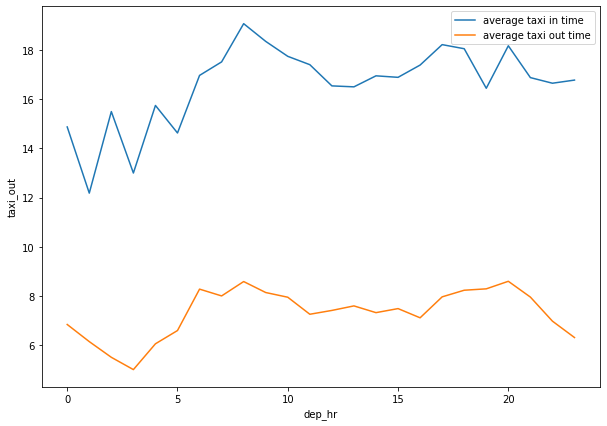

In [71]:
# mean by hr
taxi_out_mean_h = df[['dep_hr', 'taxi_out']].groupby('dep_hr', as_index=False).mean()
taxi_in_mean_h = df[['arr_hr', 'taxi_in']].groupby('arr_hr', as_index=False).mean()
fig = plt.figure(1, figsize=(10, 7))
sns.lineplot(x='dep_hr', y='taxi_out', data=taxi_out_mean_h)
sns.lineplot(x='arr_hr', y='taxi_in', data=taxi_in_mean_h)
plt.legend(labels=['average taxi in time', 'average taxi out time'])
plt.show()

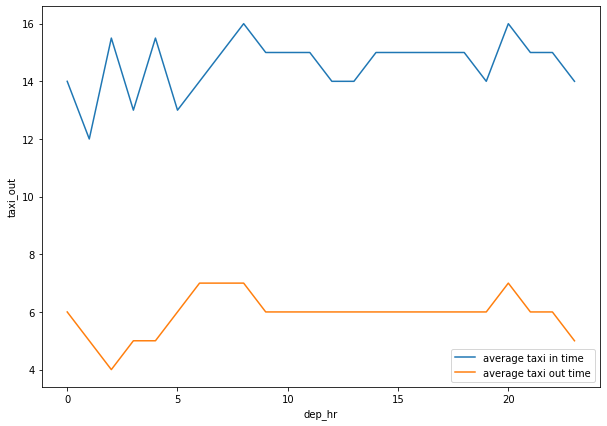

In [72]:
# median by hr
taxi_out_median_h = df[['dep_hr', 'taxi_out']].groupby('dep_hr', as_index=False).median()
taxi_in_median_h = df[['arr_hr', 'taxi_in']].groupby('arr_hr', as_index=False).median()
fig = plt.figure(1, figsize=(10, 7))
sns.lineplot(x='dep_hr', y='taxi_out', data=taxi_out_median_h)
sns.lineplot(x='arr_hr', y='taxi_in', data=taxi_in_median_h)
plt.legend(labels=['average taxi in time', 'average taxi out time'])
plt.show()

In [73]:
df['wheels_on_hr'] = (df['wheels_on'] // 100).astype('int')
df['wheels_off_hr'] = (df['wheels_off'] // 100).astype('int')

# hourly flight counts vs taxi time
traffic_taxi = pd.merge(hr_ct.set_index('dep_hr'),
                        df[['wheels_on_hr', 'arr_delay']].groupby('wheels_on_hr').count(), 
                        how='outer',
                        left_index=True,
                        right_index=True)
# hourly flights taxi counts (departure + wheel on)
traffic_taxi['total_taxi_ct'] = traffic_taxi['total_count'] + traffic_taxi['arr_delay']

traffic_taxi_time = pd.merge(taxi_in_mean_h.set_index('arr_hr'),
                             traffic_taxi,
                             how='outer',
                             left_index=True,
                             right_index=True)
traffic_taxi_time = pd.merge(taxi_out_mean_h.set_index('dep_hr'),
                             traffic_taxi_time, 
                             how='outer', 
                             left_index=True,
                             right_index=True)
traffic_taxi_time.dropna()

,taxi_out,taxi_in,total_count,arr_delay,total_taxi_ct
0,14.875000,6.835897,40.0,241,281.0
1,12.181818,6.138889,11.0,76,87.0
2,15.500000,5.500000,2.0,28,30.0
3,13.000000,5.000000,4.0,11,15.0
4,15.750000,6.050000,4.0,44,48.0
5,14.629032,6.590000,372.0,122,494.0
6,16.971910,8.274900,1068.0,328,1396.0
7,17.522330,7.998188,1030.0,572,1602.0
8,19.077801,8.583221,964.0,765,1729.0
9,18.356425,8.136523,895.0,881,1776.0


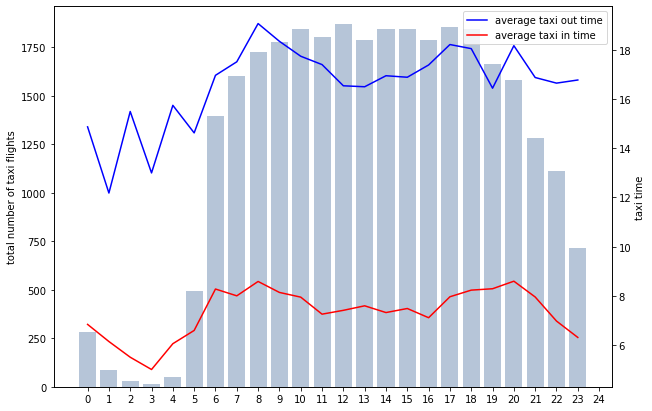

In [74]:
fig = plt.figure(1, figsize=(10, 7))
sns.barplot(x=traffic_taxi_time.index, y='total_taxi_ct', data=traffic_taxi_time, color="lightsteelblue")
plt.ylabel('total number of taxi flights')
ax2 = plt.twinx()
sns.lineplot(x=traffic_taxi_time.index, y='taxi_out', data=traffic_taxi_time, color="b", ax=ax2)
sns.lineplot(x=traffic_taxi_time.index, y='taxi_in', data=traffic_taxi_time, color="r", ax=ax2)
plt.ylabel('taxi time')
plt.legend(labels=['average taxi out time', 'average taxi in time'])
plt.show()

#### **Task 5**
What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?
##### Departure Delay

In [75]:
# total number of delay flights
delay_ct = df[df['arr_delay'] >= 15]['arr_delay'].count()

#total number of departure delay flights
dep_delay_ct = df[df['dep_delay'] >= 15]['arr_delay'].count()

# dataframe of all arrival delayed flights
dep_arr_delay = df[df['arr_delay'] >= 15][['dep_delay', 'arr_delay']]

# number of flights that the arrival delayed was mainly caused by departure delay (threshold=0.5)
dep_delay_main = ((dep_arr_delay['dep_delay'] / dep_arr_delay['arr_delay']) > 0.5).sum()

#pct
dep_delay_main / delay_ct

0.7804030576789437

In [76]:
# number of departure delayed flights that has lowered delay during flying
dep_delay_lowered = ((dep_arr_delay['dep_delay'] > dep_arr_delay['arr_delay'])).sum()
# pct of all departure delayed flights
dep_delay_lowered / dep_delay_main

0.5997328584149599

Impact of Departure Delays

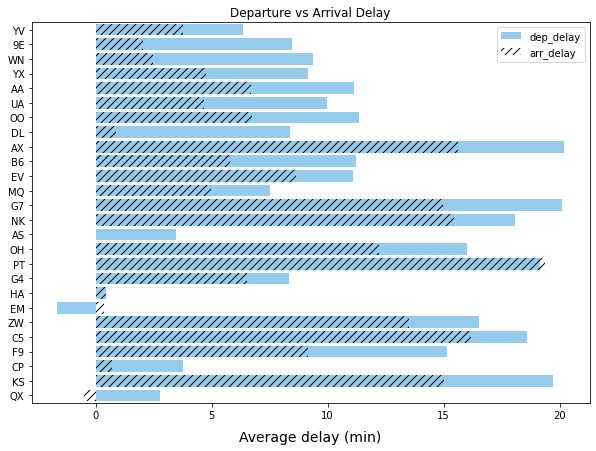

In [77]:
fig = plt.figure(1, figsize=(10,7))
ax = sns.barplot(x="dep_delay", y="op_unique_carrier", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="arr_delay", y="op_unique_carrier", data=df, color='lightskyblue', hatch = '///', alpha = 0.0, ci=None)
ax.yaxis.label.set_visible(False)
plt.title('Departure vs Arrival Delay')
plt.xlabel('Average delay (min)', fontsize=14, labelpad=10);
plt.legend(labels=['dep_delay', 'arr_delay'])

##### Delay Types

In [78]:
delay_types = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

# count number of delay types in each delay
df['delay_type_ct'] = np.count_nonzero(df[delay_types], axis=1)

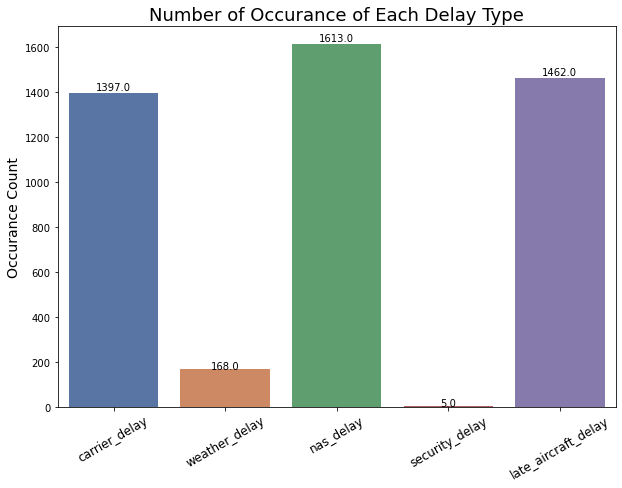

In [79]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)


# how many times did each delay type happen?
fig = plt.figure(1, figsize=(10,7))
p = sns.barplot(x=delay_types, y=np.count_nonzero(df[delay_types], axis=0), palette='deep')
plt.xticks(rotation=30, fontsize=12)
plt.ylabel('Occurance Count', fontsize=14)
plt.title('Number of Occurance of Each Delay Type', fontsize=18)
show_values(p)
plt.show()

<AxesSubplot:xlabel='delay_type', ylabel='delay_time'>

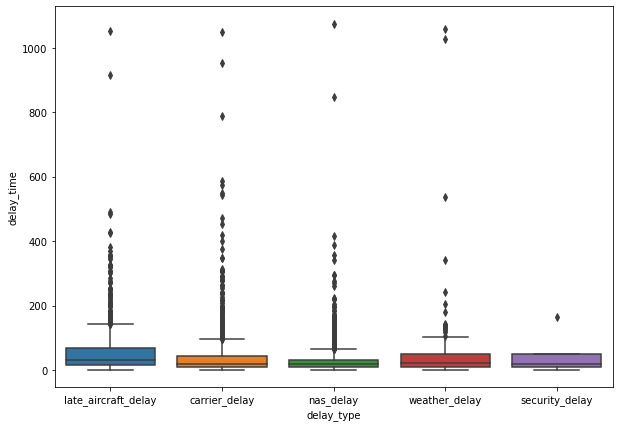

In [80]:
# which delay type might cause longer delay time
delay_type_time = pd.DataFrame(df[delay_types].T.unstack()).reset_index(1).rename(columns={'level_1':'delay_type', 0:'delay_time'})
delay_type_time = delay_type_time[delay_type_time['delay_time'] > 0]
fig = plt.figure(1, figsize=(10,7))
# for col in delay_types:
sns.boxplot(x='delay_type', y='delay_time', data=delay_type_time)

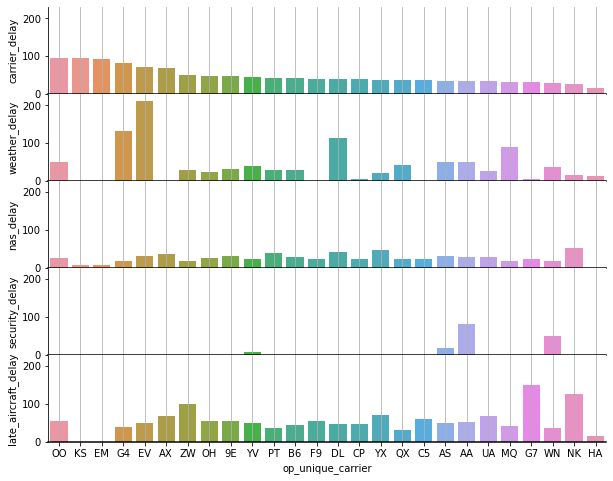

In [81]:
# average delay time of each delay type from each carrier
carrier_delay_type_time = df[['op_unique_carrier', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].set_index('op_unique_carrier').T.unstack().reset_index().rename(columns={'level_1':'delay_type', 0:'delay_time'})
carrier_delay_type_time = carrier_delay_type_time[carrier_delay_type_time['delay_time'] > 0].groupby(['op_unique_carrier', 'delay_type']).mean().unstack(0).T.reset_index().drop(columns={'level_0', 'arr_delay'}).sort_values('carrier_delay', ascending=False)

# Set up the matplotlib figure
f, axes = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
plt.subplots_adjust(hspace=.0)

x = carrier_delay_type_time['op_unique_carrier']

for i in range(len(delay_types)):
    y = carrier_delay_type_time[delay_types[i]]
    sns.barplot(x=x, y=y, ax=axes[i])
    axes[i].axhline(0, color="k", clip_on=False)
    axes[i].set_ylabel(delay_types[i])
    axes[i].set_ylim((0,230))
    axes[i].xaxis.grid(True)

# Finalize the plot
sns.despine(bottom=True, right=True, top=True)

#### **Task 6**
How many states cover 50% of US air traffic? 

##### State Coverage

In [82]:
(df['origin_state'].value_counts() / df.shape[0]).cumsum().head(8)

 CA    0.116192
 TX    0.216548
 FL    0.291370
 IL    0.346397
 GA    0.398060
 NY    0.446094
 CO    0.491884
 NC    0.536487
Name: origin_state, dtype: float64

In [83]:
(df['dest_state'].value_counts() / df.shape[0]).cumsum().head(8)

 CA    0.112761
 TX    0.212589
 FL    0.287477
 IL    0.350884
 GA    0.403273
 NY    0.450779
 NC    0.495843
 CO    0.533584
Name: dest_state, dtype: float64

#### **Task 7**
Test the hypothesis whether planes fly faster when there is the departure delay? 
##### Departure delay impact on flight speed

In [84]:
dep_delay_elapsed_time = df[df['dep_delay'] > 15][['crs_elapsed_time', 'actual_elapsed_time']]

stat, p = stats.f_oneway(dep_delay_elapsed_time['crs_elapsed_time'], dep_delay_elapsed_time['actual_elapsed_time'])
print('H0: There\'s no speed diference.')
print('Reject H0' if p < 0.05 else 'Accept H0')

H0: There's no speed diference.
Reject H0


<AxesSubplot:ylabel='Count'>

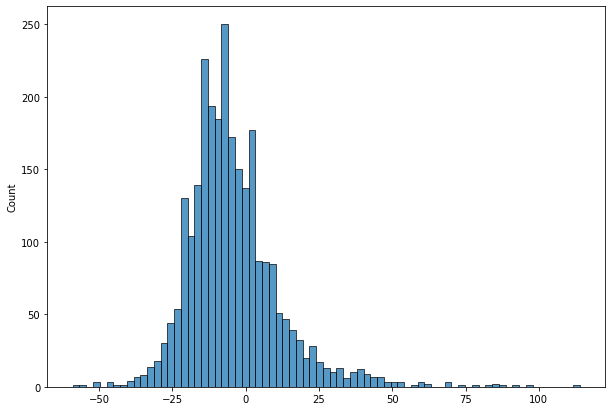

In [85]:
fig = plt.figure(1, figsize=(10, 7))
sns.histplot(dep_delay_elapsed_time['actual_elapsed_time'] - dep_delay_elapsed_time['crs_elapsed_time'])

In [86]:
# actual_elapsed_time vs crs_elapsed_time

#### **Task 8**
When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [87]:
labels = ['short','medium','long']
df['haul_fl'] = pd.cut(df['crs_elapsed_time'], bins=3, labels=labels)

(0.0, 23.0)

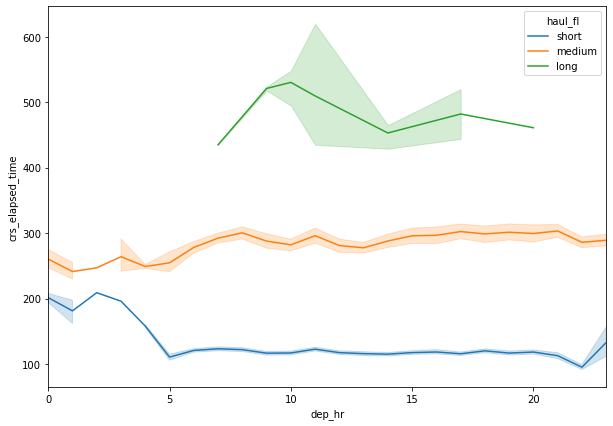

In [88]:
fig = plt.figure(1, figsize=(10, 7))
sns.lineplot(x='dep_hr', y='crs_elapsed_time', hue='haul_fl', data=df)
plt.xlim((0,23))

#### **Task 9**
Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [89]:
# upload datasets
passengers = pd.read_csv('data/passengers_raw.csv', index_col=0)
passengers.head()

,departures_scheduled,departures_performed,payload,seats,passengers,freight,mail,distance,ramp_to_ramp,air_time,...,dest_country,dest_country_name,aircraft_group,aircraft_type,aircraft_config,year,month,distance_group,class,data_source
0,0.0,20.0,276001.0,1000.0,936.0,0.0,0.0,254.0,0.0,0.0,...,US,United States,4,484,1,2019,6,1,F,IF
1,0.0,27.0,405000.0,1350.0,1281.0,0.0,0.0,254.0,0.0,0.0,...,US,United States,6,629,1,2019,6,1,F,IF
2,0.0,15.0,341251.0,1140.0,974.0,0.0,0.0,254.0,0.0,0.0,...,US,United States,6,638,1,2019,6,1,F,IF
3,0.0,56.0,840000.0,2800.0,2147.0,0.0,0.0,460.0,0.0,0.0,...,US,United States,6,629,1,2019,6,1,F,IF
4,0.0,55.0,825000.0,2750.0,2384.0,0.0,0.0,487.0,0.0,0.0,...,US,United States,6,629,1,2019,6,1,F,IF


In [90]:
passengers['year'].value_counts()

2019    4911
2016    4839
2015    4713
2017    4511
2018    4259
Name: year, dtype: int64

In [91]:
#Find the top 10 the bussiest airlines
busy_airlines= df['op_unique_carrier'].value_counts().head(10)
busy_airlines

WN    2415
DL    1902
AA    1832
UA    1294
OO    1227
B6     769
OH     571
YV     564
AS     527
MQ     496
Name: op_unique_carrier, dtype: int64

In [92]:
#Find the top 10 the bussiest origin airports
busy_airports = df[['origin_airport_id', 'fl_month']].groupby('origin_airport_id', as_index=False).count().rename(columns={'fl_month': 'flights'})
busy_airports.head(10)

,origin_airport_id,flights
0,10135,10
1,10136,3
2,10140,85
3,10141,2
4,10146,3
5,10154,1
6,10155,3
7,10158,3
8,10185,5
9,10208,12


In [93]:
crowded_airports = passengers[passengers['year'].isin([2018,2019])][['origin_airport_id', 'passengers']].groupby('origin_airport_id', as_index=False).sum().sort_values(by='passengers', ascending=False)
crowded_airports.head(10)

,origin_airport_id,passengers
444,13930,776404.0
35,10397,633047.0
149,11292,620860.0
539,14771,535358.0
335,12892,521940.0
189,11618,507847.0
537,14747,499361.0
404,13487,494218.0
200,11697,482282.0
298,12478,462540.0


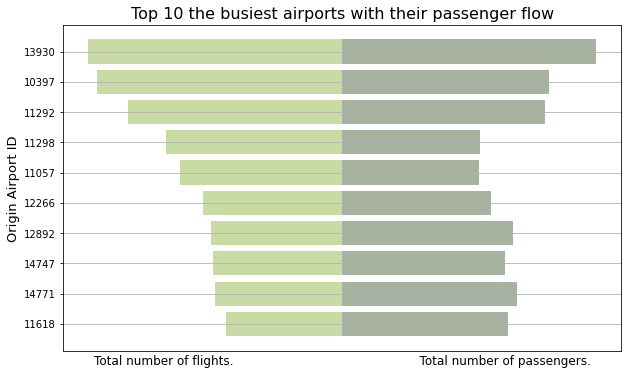

In [110]:
airport_fl_psg = pd.merge(busy_airports,
                          crowded_airports, 
                          on='origin_airport_id', 
                          how='outer')
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(airport_fl_psg[['flights', 'passengers']]),
                    columns=['flights', 'passengers'])
data['origin_airport_id'] = airport_fl_psg['origin_airport_id']
data = data.sort_values('flights').sort_values(by='flights', ascending=False).head(10).sort_values(by='flights')

# Create a figure
fig = plt.figure(figsize=(10,6))

# Set the y position
y_pos = data['origin_airport_id'].astype('str')

plt.barh(y_pos, 
         -data['flights'],
         align='center', 
         alpha=0.4, 
         color='#77A61D')

plt.barh(y_pos, 
         data['passengers'],
         align='center', 
         alpha=0.4, 
         color='#263F13')

# annotation and labels             
plt.xlabel('Total number of flights.                                                Total number of passengers.', fontsize=12)
plt.ylabel('Origin Airport ID', fontsize=13)
plt.xticks([])
plt.title('Top 10 the busiest airports with their passenger flow', fontsize=16)
plt.grid()
plt.show()

#### **Task 10**
Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [111]:
fuel = pd.read_csv('data/fuel_comsumption_raw.csv', index_col=0)
fuel.head()

,month,airline_id,unique_carrier,carrier,carrier_name,carrier_group_new,sdomt_gallons,satl_gallons,spac_gallons,slat_gallons,...,sdomt_cost,satl_cost,spac_cost,slat_cost,sint_cost,ts_cost,tdomt_cost,tint_cost,total_cost,year
0,1,NaN,NaN,0JQ,NaN,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5100.0,0.0,5100.0,2016
1,1,21352.0,0WQ,0WQ,Avjet Corporation,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,396216.0,140239.0,536455.0,2016
2,1,21645.0,23Q,23Q,Songbird Airways Inc.,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
3,1,21652.0,27Q,27Q,"Jet Aviation Flight Services, Inc.",1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
4,1,20408.0,5V,5V,Tatonduk Outfitters Limited d/b/a Everts Air A...,1,260848.0,0.0,0.0,0.0,...,522405.0,0.0,0.0,0.0,0.0,522405.0,569497.0,0.0,569497.0,2016


In [112]:
carrier_month_delay = df_2018[df_2018['arr_delay'] > 15][['op_unique_carrier', 'fl_month', 'arr_delay']].groupby(['op_unique_carrier', 'fl_month']).sum().unstack().mean(axis=1)

carrier_month_distance = df_2018[['op_unique_carrier', 'fl_month', 'distance']].groupby(['op_unique_carrier', 'fl_month']).sum().unstack().mean(axis=1)

psg_2018 = passengers[passengers['year']==2018]
carrier_month_psg = psg_2018[['unique_carrier', 'month', 'passengers']].groupby(['unique_carrier', 'month']).sum().unstack().mean(axis=1)

fuel_2018 = fuel[fuel['year']==2018]
carrier_month_fuel = fuel_2018[['unique_carrier', 'month', 'total_gallons']].groupby(['unique_carrier', 'month']).sum().unstack().mean(axis=1)

In [113]:
df_delay_comsumption = pd.concat([carrier_month_delay, carrier_month_distance, carrier_month_psg, carrier_month_fuel], axis=1).rename(columns={0:'delay', 1:'distance', 2:'passenger', 3:'fuel'})
df_delay_comsumption['distance'] *= 1.60934
df_delay_comsumption['avg_fuel_psg_km'] = df_delay_comsumption['fuel'] / df_delay_comsumption['passenger'] / df_delay_comsumption['delay']
df_delay_comsumption.head()

,delay,distance,passenger,fuel,avg_fuel_psg_km
9E,627.400000,28866.731580,13003.200000,0.000000e+00,0.000000
AA,1061.250000,123163.058423,76460.083333,3.036858e+08,3.742588
AS,301.166667,73038.516466,41762.888889,6.056769e+07,4.815524
AX,502.000000,17551.462040,5818.333333,NaN,NaN
B6,387.714286,68810.751547,43349.000000,7.076390e+07,4.210376


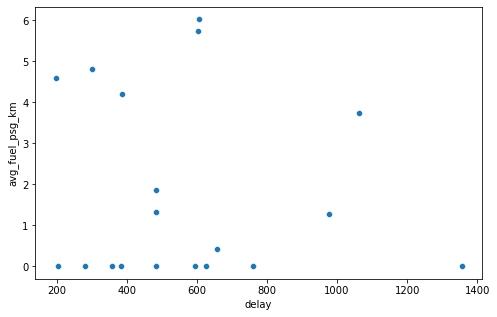

In [114]:
fig = plt.figure(1, figsize=(8,5))
sns.scatterplot(x='delay', y='avg_fuel_psg_km', data=df_delay_comsumption)
plt.show()

#### More About Carriers
##### Flights counts per airline

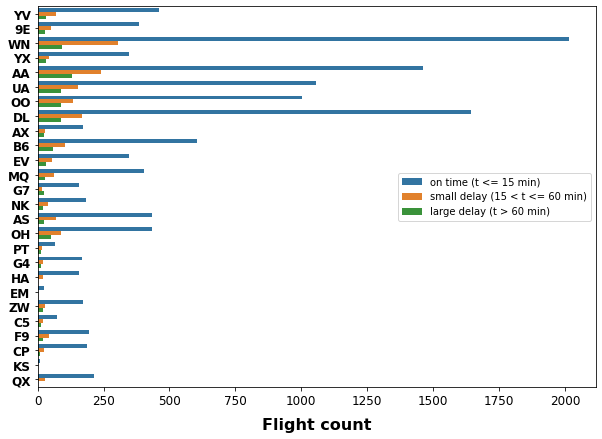

In [115]:
# Function that define how delays are grouped
df['delay_level'] = df['arr_delay'].apply(lambda x:((0,1)[x > 15],2)[x > 60])

fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="op_unique_carrier", hue='delay_level', data=df)

# replace the abbreviations by the full names of the companies and set the labels
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t <= 15 min)')
L.get_texts()[1].set_text('small delay (15 < t <= 60 min)')
L.get_texts()[2].set_text('large delay (t > 60 min)')
plt.show()

In [116]:
# Creation of a dataframe with statitical infos on each airline:
airline_delay = df['arr_delay'].groupby(df['op_unique_carrier']).agg({'min', 'max', 'mean', 'median', 'count'}).sort_values('mean')
airline_delay.head(10)

,min,median,mean,count,max
op_unique_carrier,,,,,
QX,-32.0,-5.0,-0.516393,244,148.0
AS,-94.0,-8.0,0.022770,527,210.0
EM,-17.0,-1.0,0.375000,24,101.0
HA,-30.0,-3.0,0.464088,181,81.0
CP,-31.0,-4.0,0.694064,219,146.0
DL,-60.0,-9.0,0.889590,1902,1075.0
9E,-49.0,-10.0,2.038961,462,373.0
WN,-36.0,-5.0,2.469979,2415,413.0
YV,-46.0,-4.0,3.767730,564,283.0


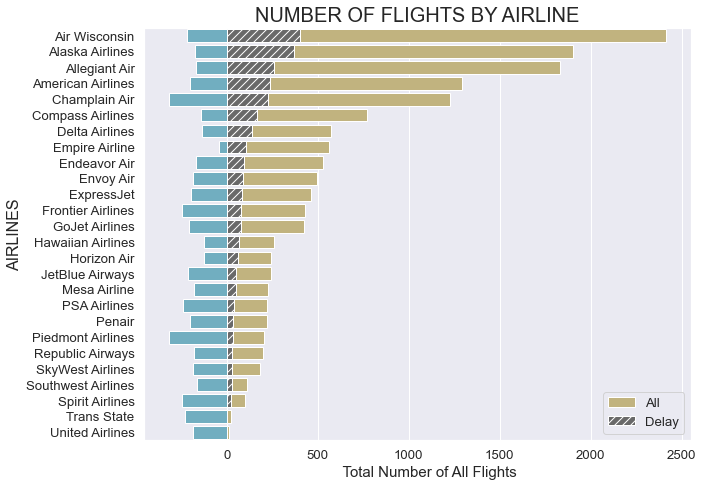

In [135]:
df['carrier_name'] = df['op_unique_carrier'].replace({
    'UA':'United Airlines',
    'AS':'Alaska Airlines',
    '9E':'Endeavor Air',
    'B6':'JetBlue Airways',
    'EV':'ExpressJet',
    'F9':'Frontier Airlines',
    'G4':'Allegiant Air',
    'HA':'Hawaiian Airlines',
    'MQ':'Envoy Air',
    'NK':'Spirit Airlines',
    'OH':'PSA Airlines',
    'OO':'SkyWest Airlines',
    'VX':'Virgin America',
    'WN':'Southwest Airlines',
    'YV':'Mesa Airline',
    'YX':'Republic Airways',
    'AA':'American Airlines',
    'DL':'Delta Airlines',
    'QX':'Horizon Air',
    'CP':'Compass Airlines',
    'AX':'Trans State',
    'G7':'GoJet Airlines',
    'ZW':'Air Wisconsin',
    'PT':'Piedmont Airlines',
    'C5':'Champlain Air',
    'EM':'Empire Airline',
    'KS':'Penair',
    '9K':'Cape Air'
})

df_delay = df[df['arr_delay']>15]
carrier_delay_ct = df_delay.carrier_name.value_counts()
carrier_ct = df.carrier_name.value_counts()
carrier_delay_pct = pd.DataFrame(carrier_delay_ct / carrier_ct).reset_index().rename(columns={'index': 'carrier_name', 'carrier_name':'pct'})

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
ax = sns.countplot(y='carrier_name', data=df, order=df['carrier_name'].value_counts().iloc[0:28].index, color='y')
ax = sns.countplot(y='carrier_name', data=df_delay, order=df_delay['carrier_name'].value_counts().iloc[0:28].index, color='dimgrey', hatch='///')
plt.legend(labels=['All', 'Delay'])
ax = sns.barplot(x=-1000*carrier_delay_pct['pct'], y=carrier_delay_pct['carrier_name'], color='c')

plt.title('NUMBER OF FLIGHTS BY AIRLINE', fontsize=20)
plt.ylabel('AIRLINES', fontsize=16)
plt.xlabel('      Total Number of All Flights', fontsize=15)
plt.tight_layout()
plt.show()

##### Average Delay Time per Airline

In [118]:
airline_delay = df[['op_unique_carrier', 'arr_delay']].groupby('op_unique_carrier', as_index=False).mean().sort_values('arr_delay')
airline_delay.head()

,op_unique_carrier,arr_delay
20,QX,-0.516393
2,AS,0.022770
8,EM,0.375000
13,HA,0.464088
6,CP,0.694064


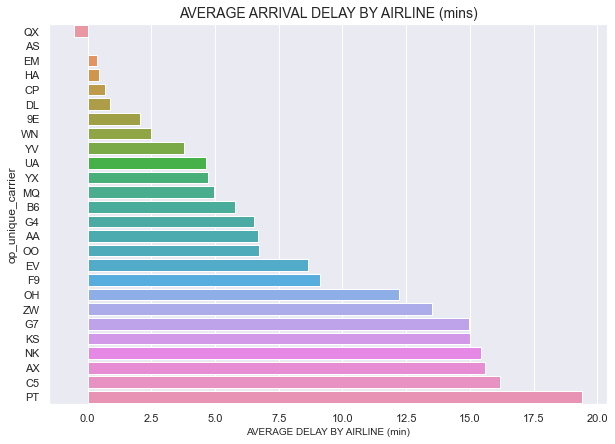

In [119]:
fig = plt.figure(1, figsize=(10,7))
sns.set(font_scale=1.0)
ax = sns.barplot(x='arr_delay', y='op_unique_carrier', data=airline_delay)
ax.set_title('AVERAGE ARRIVAL DELAY BY AIRLINE (mins)', fontsize=14)
ax.set_xlabel('AVERAGE DELAY BY AIRLINE (min)', fontsize=10)
plt.show()

In [54]:
# need target variable transformation